# Benchmarking randomized circuits using Quantum state tomography
# For REAL backend (GHZ)


In [1]:
def randomized_circuit(q_input, circ_number):
    from qiskit.compiler import transpile
    from qiskit.transpiler.passes import RemoveBarriers
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import XGate, YGate, ZGate, IGate
    import numpy as np

    ## define easy and hard gates
    easy_gate = ['u3', 'id']
    hard_gate = ['cx']
    twirling = ['id', 'x', 'y', 'z']

    ## transpile the input gate to the equivalent gate with easy and hard gates basis
    q_transform = transpile(q_input, basis_gates=['u3', 'cx', 'id'], optimization_level=3)

    random_circuit_set = []
    running_qubits = [0, 1, 2]

    ## set easy_layer sets and hard_layer sets
    easy_layer = []
    hard_layer = []
    easy_layer_comp = []
    hard_seeker = False
    for gate in q_transform.data:
        if gate[0].name in hard_gate:
            hard_layer.append(gate)
            hard_seeker=True
            easy_layer.append(easy_layer_comp)
            easy_layer_comp=[]
        elif gate[0].name in easy_gate:
            if hard_seeker:
                hard_seeker=False
                easy_layer_comp=[]
            easy_layer_comp.append(gate)
    easy_layer.append(easy_layer_comp)

    def random_T():
        rand_value = np.random.randint(4)
        if rand_value == 0:
            return XGate()
        elif rand_value == 1:
            return YGate()
        elif rand_value == 2:
            return ZGate()
        elif rand_value == 3:
            return IGate()

    depth_easy = len(easy_layer)
    depth_hard = len(hard_layer)
    depth = depth_easy + depth_hard

    for _ in np.arange(circ_number):
        T_set = []
        for _ in range(depth_hard):
            T_comp = []
            for _ in running_qubits:
                T = random_T()
                T_comp.append(T)
            T_set.append(T_comp)

        q_out = QuantumCircuit(q_transform.num_qubits)
        for ind in range(depth//2 + 1):
            # Hard layer
            if ind > 0:
                q_out.barrier()
                q_out.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
                q_out.barrier()
            # Tc + easy + T layer (No Tc at the first layer, no T at the final layer)
            ## Tc
            q_temp = QuantumCircuit(q_transform.num_qubits)
            if ind > 0:
                q_temp.compose(hard_layer[ind - 1][0].reverse_ops(), hard_layer[ind - 1][1], inplace=True)
                for T_ind, T in zip(running_qubits, T_set[ind-1]):
                    q_temp.compose(T.reverse_ops(), [T_ind], inplace=True)
                q_temp.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
            ## easy
            for sub_ind in np.arange(len(easy_layer[ind])):
                q_temp.compose(easy_layer[ind][sub_ind][0], easy_layer[ind][sub_ind][1], inplace=True)
            ## T
            if (ind < depth//2):
                for T_ind, T in zip(running_qubits, T_set[ind]):
                    q_temp.compose(T, [T_ind], inplace=True)
            q_temp = transpile(q_temp, basis_gates=['id', 'u3', 'cx'], optimization_level=3)

            q_out.compose(q_temp, range(q_transform.num_qubits), inplace=True)
        q_out = RemoveBarriers()(q_out)
        q_out = transpile(q_out, basis_gates=['id', 'u3', 'cx'], optimization_level=3)

        random_circuit_set.append(q_out)

    return random_circuit_set

In [2]:
def rc_real_backend_execute(original_circuit, randomized_circuits, backend, initial_layout, schedule, shots=1000):
    from qiskit.compiler import transpiler
    from qiskit import execute

    job_circ_list = []
    original_circuit_ = original_circuit.copy()
    original_circuit_.measure_all()
    original_circuit_ = transpile(original_circuit_, backend=backend, initial_layout=initial_layout, scheduling_method=schedule, optimization_level=3)
    job_circ_list.append(original_circuit_)
    for rc in randomized_circuits:
        rc_ = rc.copy()
        rc_.measure_all()
        rc_ = transpile(rc_, backend=backend, initial_layout=initial_layout, scheduling_method=schedule, optimization_level=3)
        job_circ_list.append(rc_)
    job = execute(job_circ_list, backend=backend, shots=shots)

    return job

In [3]:
def tvd_benchmark_rc_circuit_for_real_post_call(original_circuit, randomized_circuits, job, shots=1000):
    from qiskit.quantum_info import Statevector

    n_random_circs = len(randomized_circuits)
    state_vector = Statevector.from_instruction(original_circuit)
    ideal_probabilities = state_vector.probabilities_dict()

    bare_counts = job.result().get_counts()[0]
    bare_counts = {key: value for key, value in sorted(bare_counts.items())}

    rc_counts_list = []
    for k in range(n_random_circs):
        rc_counts_list.append(job.result().get_counts()[1 + k])
    keys = set().union(*rc_counts_list)
    rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
    rc_counts = {key: value for key, value in sorted(rc_counts.items())}

    tvd_bare = sum(0.5 * abs(ideal_probabilities.get(key, 0) - bare_counts.get(key, 0) / shots)
                   for key in ideal_probabilities.keys() | bare_counts.keys())
    tvd_random = sum(0.5 * abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / shots / n_random_circs)
                     for key in ideal_probabilities.keys() | rc_counts.keys())

    print(ideal_probabilities)
    print('Original TVD: ', tvd_bare, bare_counts)
    print('Randomized TVD: ', tvd_random, rc_counts)

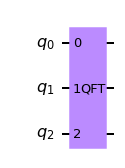

In [4]:
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit

target = QFT(3)
# target = random_circuit(3, 4)
# target = QuantumCircuit(5)
# target.h(0)
# target.cx(0, 1)
# target.cx(1, 2)
# target.cx(2, 3)
# target.cx(3, 4)
target.draw('mpl')

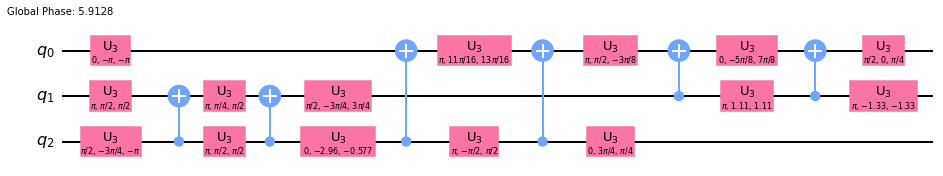

In [5]:
rc_circs = randomized_circuit(target, 10)
rc_circs[3].draw('mpl')

In [6]:
from qiskit.quantum_info import Statevector
print(Statevector.from_instruction(target).probabilities())
print(Statevector.from_instruction(rc_circs[1]).probabilities())

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [7]:
from qiskit import IBMQ, transpile
from qiskit.test.mock import FakeJakarta

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-students')
backend = provider.get_backend('ibmq_jakarta')
initial_layout = [4, 5, 6]
schedule = 'alap'

In [8]:
job = rc_real_backend_execute(target, rc_circs, backend=backend, initial_layout=initial_layout, schedule=schedule, shots=10000)

In [35]:
# job = backend.retrieve_job('62ba816ee1377d07a3098351') # GHZ 한번 더 시도
# job = backend.retrieve_job('62ba8260d529f2f0f82c9a67') # 복잡한 회로
# job = backend.retrieve_job('62ba852cd4d0c25a5b1dfbcf') # 3qubit

In [9]:
tvd_benchmark_rc_circuit_for_real_post_call(target, rc_circs, job, shots=10000)

{'000': 0.12499999999999994, '001': 0.12499999999999994, '010': 0.12499999999999994, '011': 0.12499999999999994, '100': 0.12499999999999994, '101': 0.12499999999999994, '110': 0.12499999999999994, '111': 0.12499999999999994}
Original TVD:  0.0608 {'000': 1451, '001': 1302, '010': 1556, '011': 1146, '100': 1299, '101': 1027, '110': 1209, '111': 1010}
Randomized TVD:  0.03711999999999994 {'000': 11839, '001': 12324, '010': 14889, '011': 13437, '100': 11450, '101': 11471, '110': 12886, '111': 11704}
